In [1]:
import pandas as pd
import numpy as np

df= pd.read_csv(r'D:\Python datasc\Data\FMCG_2022_2024.csv')

def analyze_dataframe(df):
    print("1. Column Names:")
    print(df.columns.tolist())
    print("\n" + "="*50 + "\n")

    print("2. Unique Values for Each Column:")
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"\n{column}:")
        print(unique_values)
        print(f"Number of unique values: {len(unique_values)}")
        print("-"*30)
    print("\n" + "="*50 + "\n")

    print("3. Null Values in the Data:")
    null_counts = df.isnull().sum()
    print(null_counts[null_counts > 0])
    
    print("\nTotal null values:", df.isnull().sum().sum())
    print("\nPercentage of null values:")
    print((df.isnull().sum() / len(df) * 100).round(2))

# Call the function with your DataFrame
analyze_dataframe(df)

1. Column Names:
['date', 'sku', 'brand', 'segment', 'category', 'channel', 'region', 'pack_type', 'price_unit', 'promotion_flag', 'delivery_days', 'stock_available', 'delivered_qty', 'units_sold']


2. Unique Values for Each Column:

date:
['2022-01-21' '2022-01-22' '2022-01-23' ... '2024-12-29' '2024-12-30'
 '2024-12-31']
Number of unique values: 1076
------------------------------

sku:
['MI-006' 'MI-026' 'YO-029' 'YO-005' 'YO-012' 'YO-014' 'YO-001' 'RE-004'
 'RE-007' 'RE-015' 'MI-023' 'JU-021' 'YO-009' 'SN-027' 'YO-003' 'MI-022'
 'YO-016' 'RE-025' 'SN-010' 'RE-017' 'SN-013' 'YO-020' 'SN-019' 'MI-002'
 'MI-011' 'YO-024' 'MI-008' 'SN-028' 'YO-018' 'SN-030']
Number of unique values: 30
------------------------------

brand:
['MiBrand1' 'MiBrand4' 'YoBrand4' 'YoBrand2' 'YoBrand1' 'YoBrand3'
 'ReBrand1' 'ReBrand4' 'MiBrand3' 'JuBrand3' 'SnBrand2' 'ReBrand2'
 'SnBrand3' 'MiBrand2']
Number of unique values: 14
------------------------------

segment:
['Milk-Seg3' 'Milk-Seg2' 'Yogurt-Seg2'

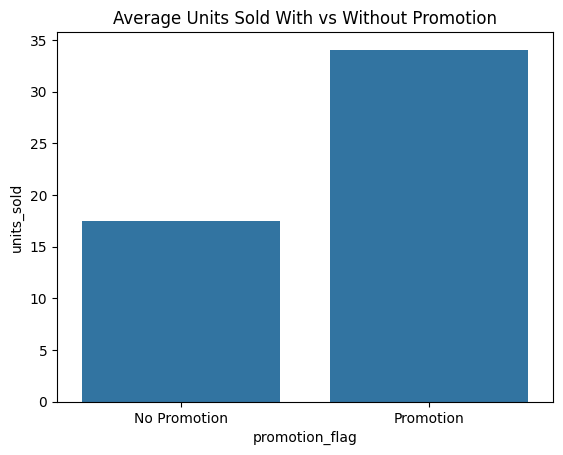

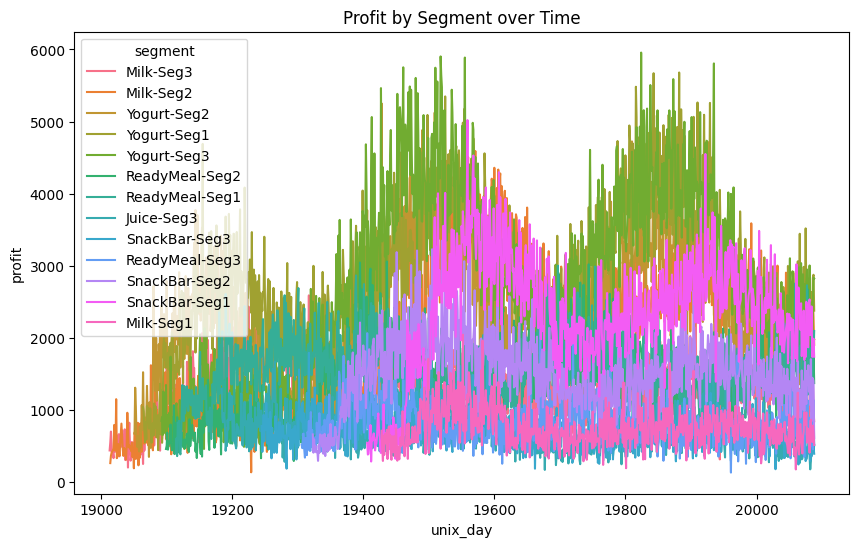

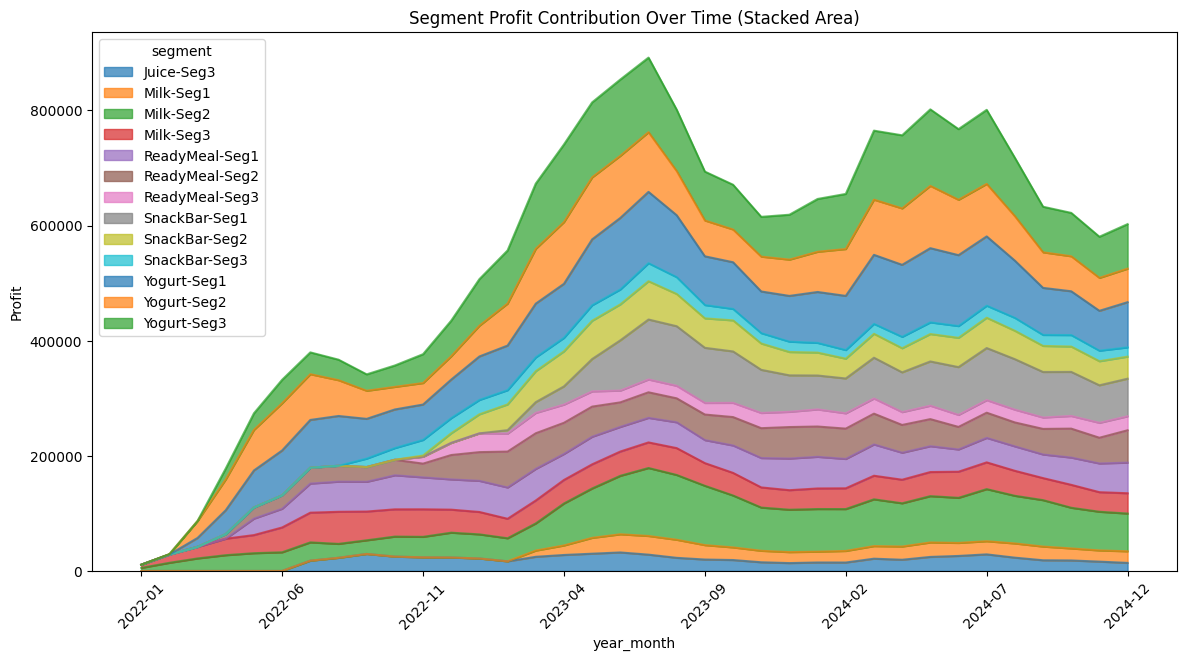

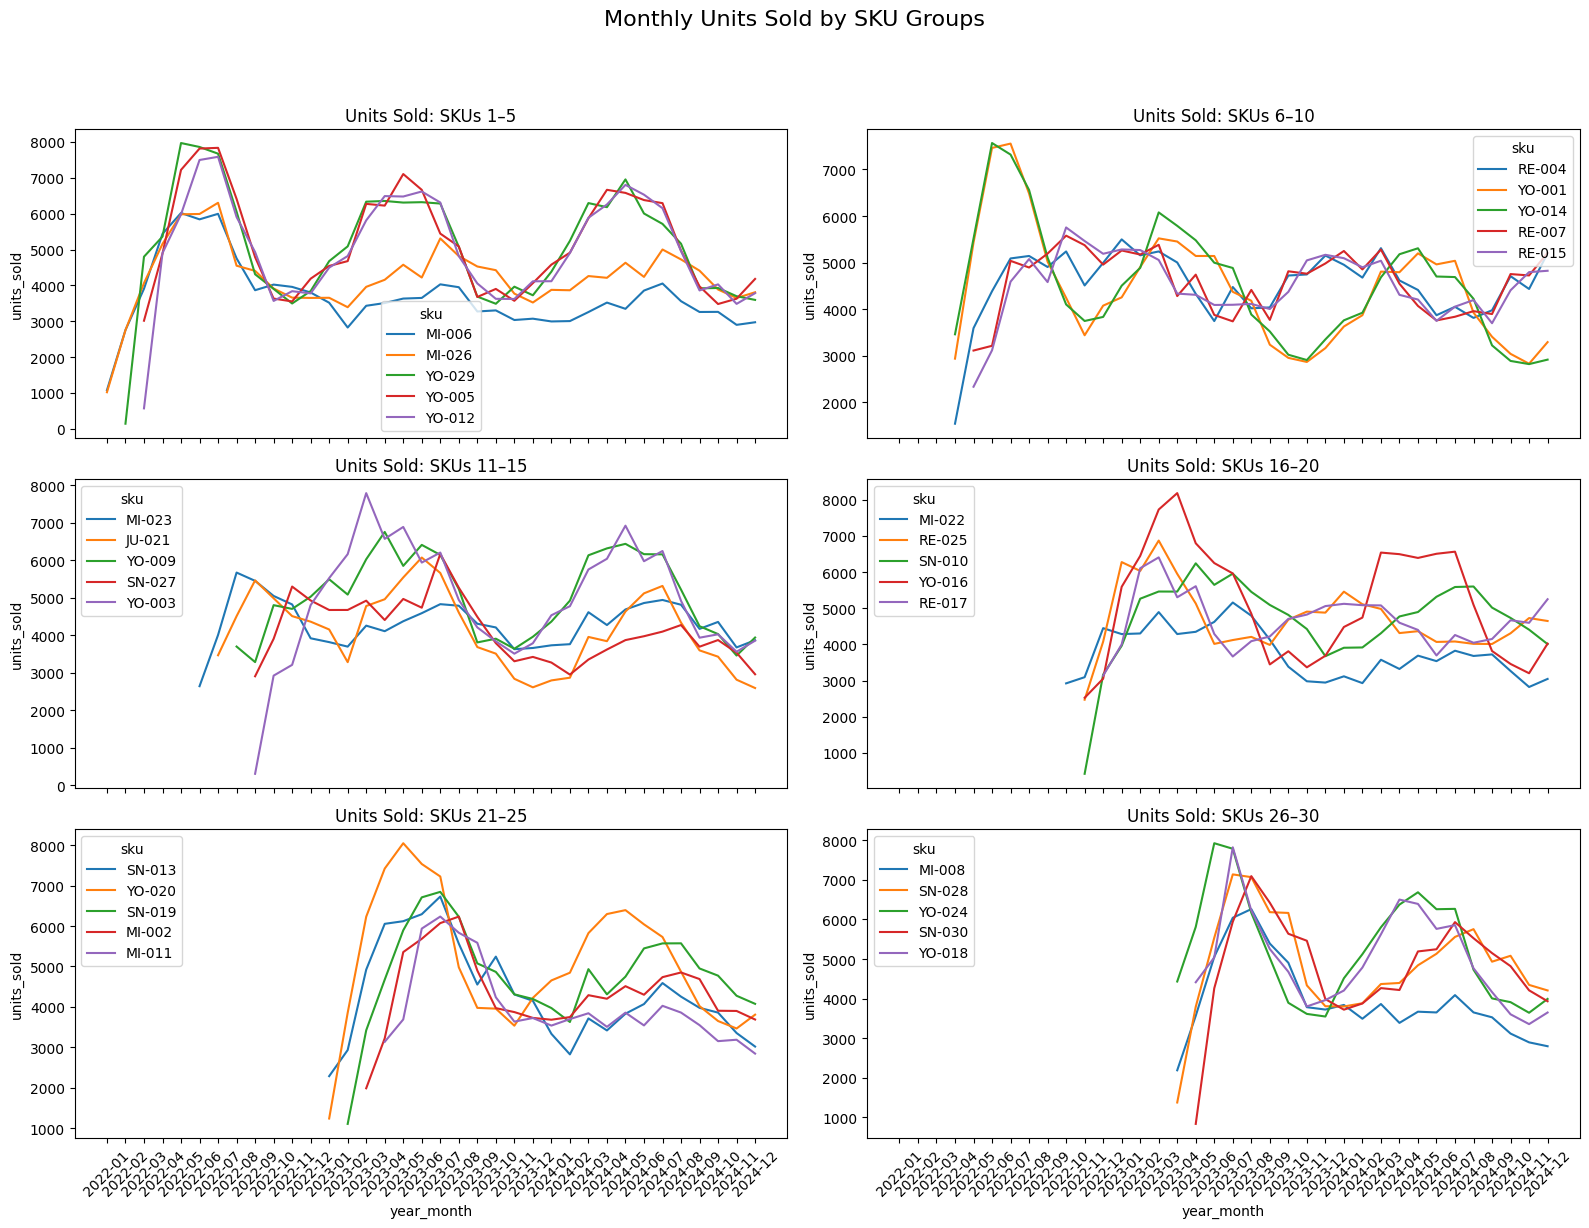

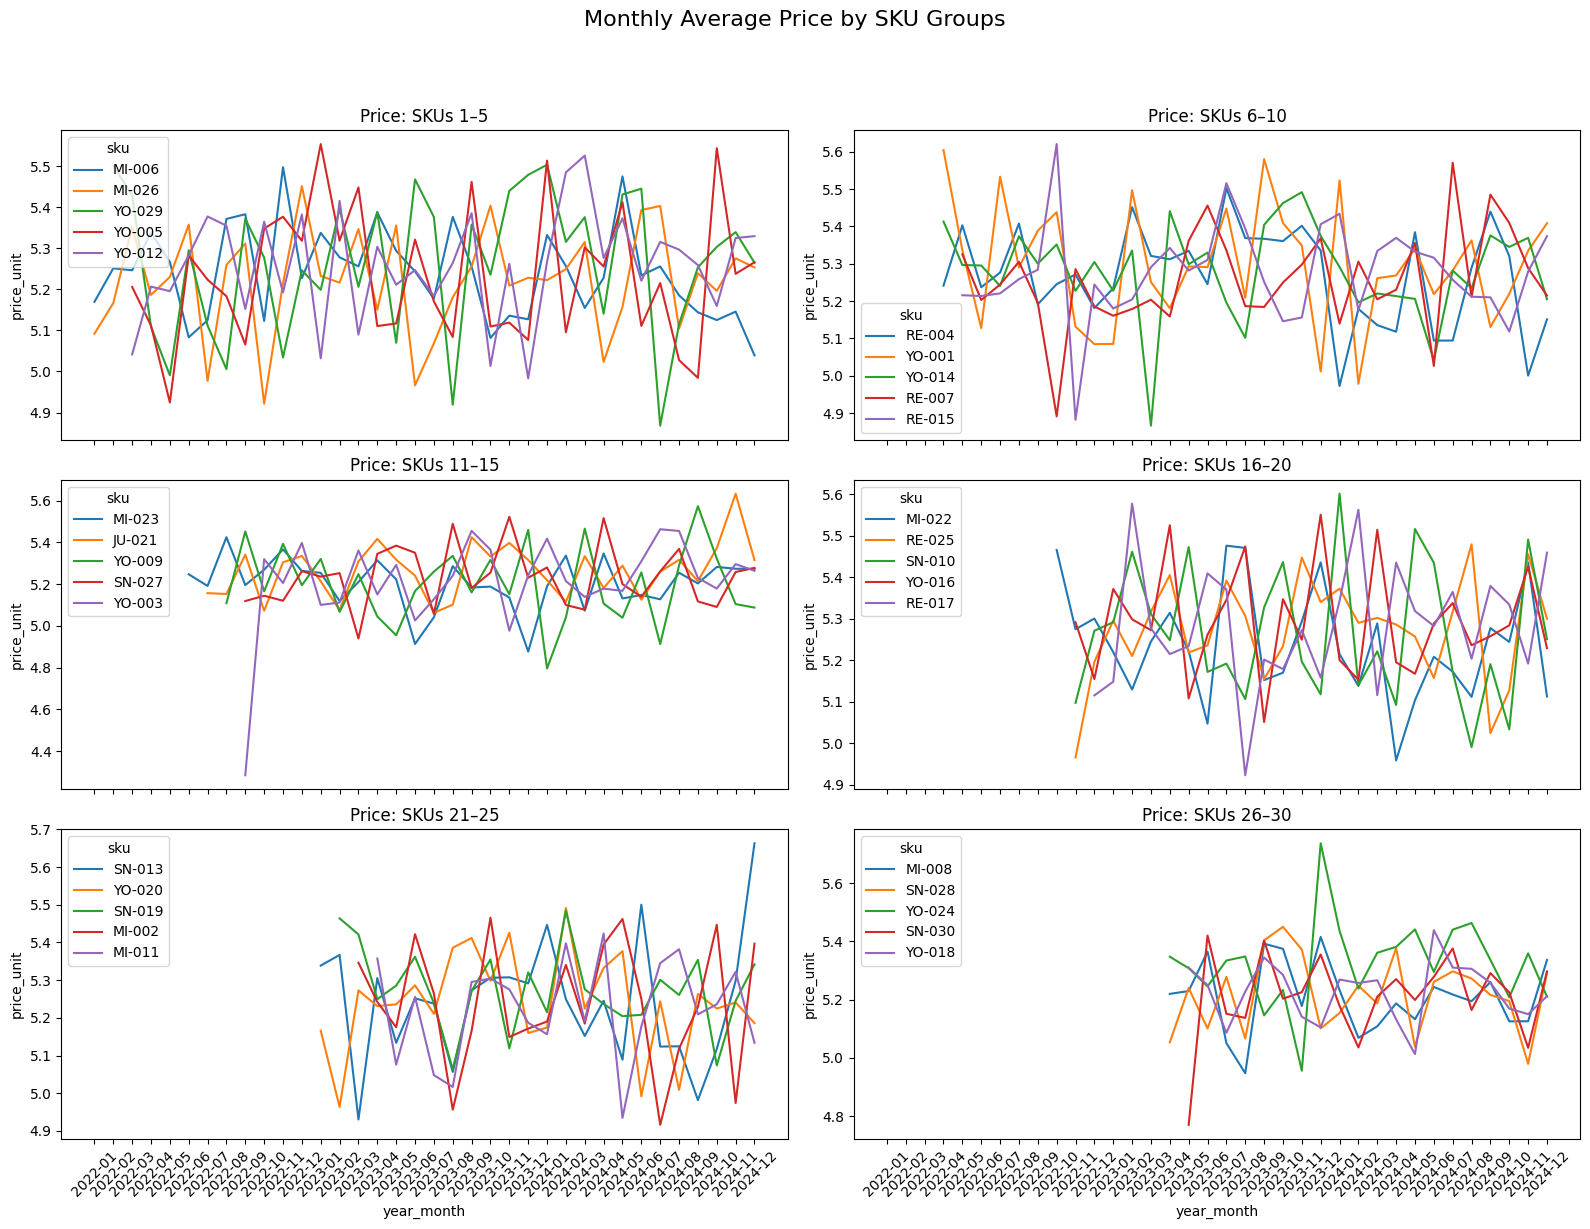

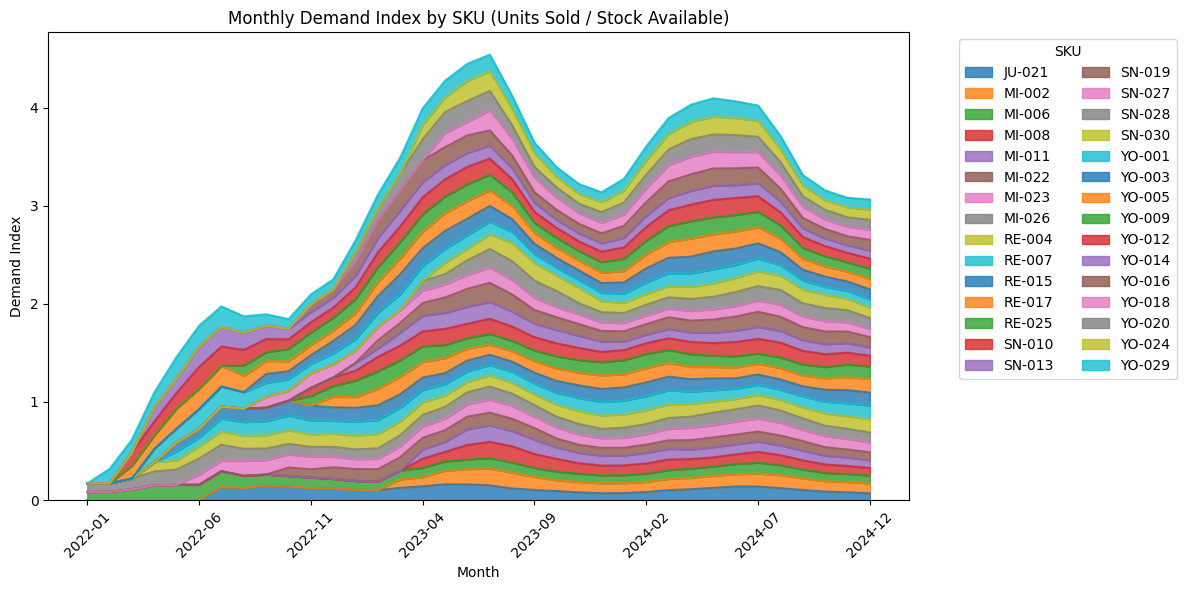

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import squarify


df= pd.read_csv(r'D:\Python datasc\Data\FMCG_2022_2024.csv')

# Convert date column to Unix epoch day (days since 1970-01-01)
df["date"] = pd.to_datetime(df["date"])
df["unix_day"] = (df["date"] - pd.Timestamp("1970-01-01")) // pd.Timedelta("1D")


# Convert date column to datetime and split into year/month/day
df["date"] = pd.to_datetime(df["date"])
df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day


# Also create year_month for grouping
df["year_month"] = df["date"].dt.to_period("M").astype(str)

# ----------------------------
# 2. Calculate profit
# ----------------------------
df["profit"] = df["price_unit"] * df["units_sold"]

# ----------------------------
# 3. Pie chart of Channel based on units_sold
# ----------------------------
channel_data = df.groupby("channel")["units_sold"].sum().reset_index()
fig1 = px.pie(channel_data, values="units_sold", names="channel", title="Channel Distribution by Units Sold")
fig1.show()

# ----------------------------
# 4. Flowmap for Region based on profit
# ----------------------------
# Note: Flow maps usually need source-target coordinates. Here we can make a Sankey-like flow
region_profit = df.groupby("region")["profit"].sum().reset_index()
fig2 = px.bar(region_profit, x="region", y="profit", title="Profit by Region")  # simple version
fig2.show()

# Or just average values
promo_effect = df.groupby("promotion_flag")["units_sold"].mean().reset_index()
promo_effect["promotion_flag"] = promo_effect["promotion_flag"].map({0: "No Promotion", 1: "Promotion"})

sns.barplot(data=promo_effect, x="promotion_flag", y="units_sold")
plt.title("Average Units Sold With vs Without Promotion")
plt.show()

# ----------------------------
# 6. Treemap of profit by SKU with Category coloring
# ----------------------------
tree_data = df.groupby(["category", "sku"])["profit"].sum().reset_index()
total_profit = tree_data["profit"].sum()
tree_data["profit_ratio"] = tree_data["profit"] / total_profit
fig3 = px.treemap(tree_data, path=["category", "sku"], values="profit_ratio", color="category", title="Treemap of Profit by SKU")
fig3.show()

# ----------------------------
# 7. Linegraph of profit by Segment
# ----------------------------
segment_profit = df.groupby(["unix_day", "segment"])["profit"].sum().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(data=segment_profit, x="unix_day", y="profit", hue="segment")
plt.title("Profit by Segment over Time")
plt.show()


# Monthly aggregation for stacked area
monthly_profit_segment = df.groupby(["year_month", "segment"])["profit"].sum().reset_index()

# Alternative visualization: stacked area chart for cumulative segment profit
def stacked_area_segment():
    pivot_data = monthly_profit_segment.pivot(index="year_month", columns="segment", values="profit").fillna(0)
    pivot_data.plot.area(figsize=(14,7), alpha=0.7)
    plt.xticks(rotation=45)
    plt.title("Segment Profit Contribution Over Time (Stacked Area)")
    plt.ylabel("Profit")
    plt.show()
stacked_area_segment()


# Get unique SKUs
sku_list = df["sku"].unique()
num_groups = len(sku_list) // 5
fig_units, axes_units = plt.subplots(nrows=3, ncols=2, figsize=(16, 12), sharex=True)
fig_price, axes_price = plt.subplots(nrows=3, ncols=2, figsize=(16, 12), sharex=True)

axes_units = axes_units.flatten()
axes_price = axes_price.flatten()

for i in range(0, len(sku_list), 5):
    group_index = i // 5
    subset_skus = sku_list[i:i+5]
    sub_df = df[df["sku"].isin(subset_skus)].copy()

    monthly_group = sub_df.groupby(["year_month", "sku"]).agg(
        units_sold=("units_sold", "sum"),
        price_unit=("price_unit", "mean")
    ).reset_index()

    # Units Sold subplot
    sns.lineplot(data=monthly_group, x="year_month", y="units_sold", hue="sku", ax=axes_units[group_index])
    axes_units[group_index].set_title(f"Units Sold: SKUs {i+1}–{i+len(subset_skus)}")
    axes_units[group_index].tick_params(axis='x', rotation=45)

    # Price subplot
    sns.lineplot(data=monthly_group, x="year_month", y="price_unit", hue="sku", ax=axes_price[group_index])
    axes_price[group_index].set_title(f"Price: SKUs {i+1}–{i+len(subset_skus)}")
    axes_price[group_index].tick_params(axis='x', rotation=45)

# 8. Monthly Units Sold by SKU Groups 
fig_units.tight_layout()
fig_units.suptitle("Monthly Units Sold by SKU Groups", fontsize=16, y=1.02)
fig_units.subplots_adjust(top=0.92)

# 9 Monthly Average Price by SKU Groups
fig_price.tight_layout()
fig_price.suptitle("Monthly Average Price by SKU Groups", fontsize=16, y=1.02)
fig_price.subplots_adjust(top=0.92)

plt.show()


# Calculate monthly demand ratio
monthly_demand = (
    df.groupby(['year_month', 'sku'])
      .agg({'units_sold':'sum', 'stock_available':'sum'})
      .reset_index()
)

# Demand index (sell-through ratio)
monthly_demand['demand_index'] = monthly_demand['units_sold'] / monthly_demand['stock_available']

# Pivot for stacked area
pivot_demand = monthly_demand.pivot(index='year_month', columns='sku', values='demand_index').fillna(0)

# Plot stacked area
pivot_demand.plot.area(figsize=(12,6), alpha=0.8)
plt.title("Monthly Demand Index by SKU (Units Sold / Stock Available)")
plt.ylabel("Demand Index")
plt.xlabel("Month")
plt.xticks(rotation=45)
plt.legend(title="SKU", bbox_to_anchor=(1.05, 1), loc='upper left',ncol=2)
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Assuming df is already loaded and cleaned

# Columns to encode
cat_cols = ["sku", "brand", "segment", "category", "channel", "region", "pack_type"]

# Apply LabelEncoder to each column and create a new encoded column
for col in cat_cols:
    le = LabelEncoder()
    df[f"{col}_encoded"] = le.fit_transform(df[col])
    print(f"{col} mapping:")
    mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    print(mapping)
    print("------------------------------")

# Preview the encoded dataframe
print(df.head())


sku mapping:
{'JU-021': 0, 'MI-002': 1, 'MI-006': 2, 'MI-008': 3, 'MI-011': 4, 'MI-022': 5, 'MI-023': 6, 'MI-026': 7, 'RE-004': 8, 'RE-007': 9, 'RE-015': 10, 'RE-017': 11, 'RE-025': 12, 'SN-010': 13, 'SN-013': 14, 'SN-019': 15, 'SN-027': 16, 'SN-028': 17, 'SN-030': 18, 'YO-001': 19, 'YO-003': 20, 'YO-005': 21, 'YO-009': 22, 'YO-012': 23, 'YO-014': 24, 'YO-016': 25, 'YO-018': 26, 'YO-020': 27, 'YO-024': 28, 'YO-029': 29}
------------------------------
brand mapping:
{'JuBrand3': 0, 'MiBrand1': 1, 'MiBrand2': 2, 'MiBrand3': 3, 'MiBrand4': 4, 'ReBrand1': 5, 'ReBrand2': 6, 'ReBrand4': 7, 'SnBrand2': 8, 'SnBrand3': 9, 'YoBrand1': 10, 'YoBrand2': 11, 'YoBrand3': 12, 'YoBrand4': 13}
------------------------------
segment mapping:
{'Juice-Seg3': 0, 'Milk-Seg1': 1, 'Milk-Seg2': 2, 'Milk-Seg3': 3, 'ReadyMeal-Seg1': 4, 'ReadyMeal-Seg2': 5, 'ReadyMeal-Seg3': 6, 'SnackBar-Seg1': 7, 'SnackBar-Seg2': 8, 'SnackBar-Seg3': 9, 'Yogurt-Seg1': 10, 'Yogurt-Seg2': 11, 'Yogurt-Seg3': 12}
---------------------

In [4]:
from sklearn.metrics import f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    r2_score,
    confusion_matrix,
    classification_report,
    log_loss,  
    confusion_matrix,
    classification_report,
    log_loss,
    mean_squared_error,
    mean_absolute_error
)
# ---------------------------
# Decision Tree Function
# ---------------------------
def run_decision_tree(df, features, target, task="regression", test_size=0.2, random_state=42):
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if task == "regression":
        model = DecisionTreeRegressor(random_state=random_state, criterion="squared_error")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Metrics
        r2 = r2_score(y_test, y_pred)
        print("Decision Tree Regression Results:")
        print("R²:", r2)
        print("MSE:", mean_squared_error(y_test, y_pred))

    else:  # classification
        model = DecisionTreeClassifier(random_state=random_state, criterion="entropy")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        print("Decision Tree Classification Results:")
        print("Accuracy:", acc)
        print("F1 Score:", f1)
        print(classification_report(y_test, y_pred))

    # Feature importance
    importance = pd.DataFrame({
        "feature": features,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(data=importance, x="importance", y="feature")
    plt.title(f"Decision Tree Feature Importance for: {target}")
    plt.show()

    return model

# ---------------------------
# Random Forest Function
# ---------------------------
def run_random_forest(df, features, target, task="regression", test_size=0.2, random_state=42):
    X = df[features]
    y = df[target]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    if task == "regression":
        model = RandomForestRegressor(random_state=random_state, n_estimators=100, criterion="squared_error")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Metrics
        r2 = r2_score(y_test, y_pred)
        print("Random Forest Regression Results:")
        print("R²:", r2)
        print("MSE:", mean_squared_error(y_test, y_pred))

    else:  # classification
        model = RandomForestClassifier(random_state=random_state, n_estimators=100, criterion="entropy")
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        # Metrics
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, average="weighted")
        print("Random Forest Classification Results:")
        print("Accuracy:", acc)
        print("F1 Score:", f1)
        print(classification_report(y_test, y_pred))

    # Feature importance
    importance = pd.DataFrame({
        "feature": features,
        "importance": model.feature_importances_
    }).sort_values("importance", ascending=False)

    plt.figure(figsize=(8,5))
    sns.barplot(data=importance, x="importance", y="feature")
    plt.title(f"Random Forest Feature Importance for: {target}")
    plt.show()

    return model


Decision Tree Classification Results:
Accuracy: 0.9119836443698889
F1 Score: 0.9121806021568905
              precision    recall  f1-score   support

           0       0.95      0.95      0.95     32475
           1       0.70      0.71      0.71      5677

    accuracy                           0.91     38152
   macro avg       0.83      0.83      0.83     38152
weighted avg       0.91      0.91      0.91     38152



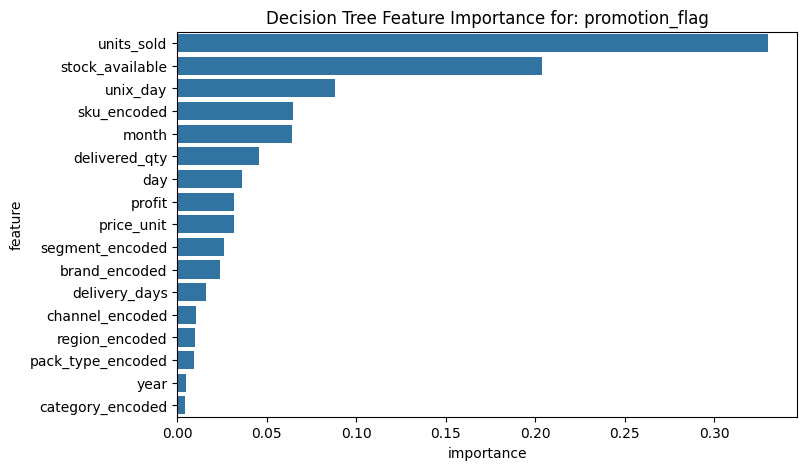

In [5]:
features = ['price_unit', 'units_sold','delivery_days', 'stock_available', 'delivered_qty', 
             'unix_day', 'year', 'month', 'day', 'profit',
               'sku_encoded', 'brand_encoded', 'segment_encoded', 'category_encoded', 'channel_encoded', 'region_encoded', 'pack_type_encoded']
target = "promotion_flag"
model_dt = run_decision_tree(df, features, target, task="classification")

Random Forest Regression Results:
R²: 0.7719361437403183
MSE: 31.715373154749425


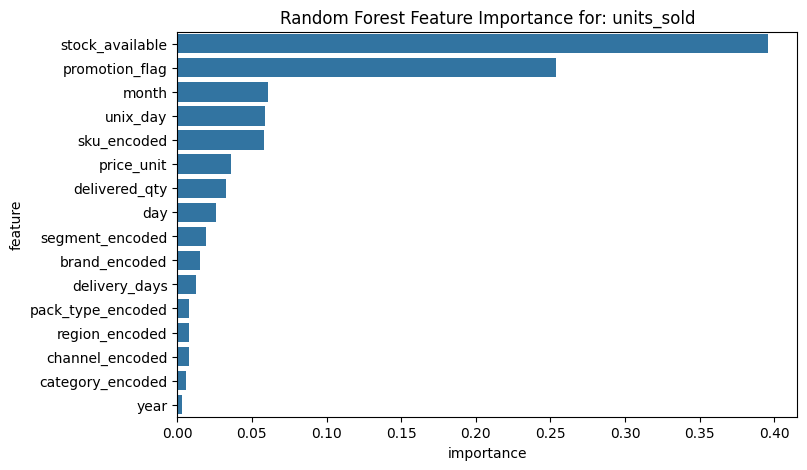

In [6]:
features = ['price_unit', 'promotion_flag', 'delivery_days', 'stock_available', 'delivered_qty', 
             'unix_day', 'year', 'month', 'day', 
               'sku_encoded', 'brand_encoded', 'segment_encoded', 'category_encoded', 'channel_encoded', 'region_encoded', 'pack_type_encoded']

target = "units_sold"   # regression example

model_rf = run_random_forest(df, features, target, task="regression")
